In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

In [2]:
# pandas로 데이터 불러오기

train_df = pd.read_csv('./dataset/digit-recognizer/train.csv')
test_df = pd.read_csv('./dataset/digit-recognizer/test.csv')


# shape 확인

print('train_df.shape =', train_df.shape)
print('test_df.shape =', test_df.shape)

train_df.shape = (42000, 785)
test_df.shape = (28000, 784)


In [3]:
# 데이터 프레임 확인

train_df

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41996,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41997,7,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
41998,6,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [4]:
# train data 정답과 이미지 분리
# data frame을 numpy array로 변환

y = train_df.iloc[:,0]
x = train_df.iloc[:,1:]

y = np.array(y)
x = np.array(x)

In [5]:
# train data와 validation data를 8:2 비율로 나누기

x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.2, random_state=36)

# train data 개수와 val data 개수 확인

print('length of x_train :', len(x_train))
print('length of x_val :', len(x_val))

length of x_train : 33600
length of x_val : 8400


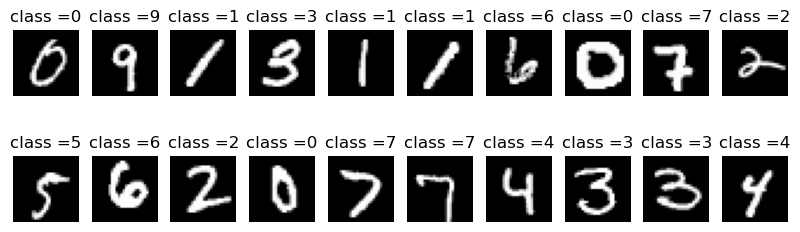

In [6]:
# x_train data 20개 시각화 및 y_train과 일치 여부 확인

import matplotlib.pyplot as plt

plt.figure(figsize=(10,3))
for i in range(20):
    plt.subplot(2,10,i+1)
    plt.axis('off')
    plt.imshow(x_train[i].reshape(28,28), cmap='gray')
    plt.title('class ='+str(y_train[i]))

In [7]:
# x_train, x_val shape을 28 * 28에 1채널(흑백)으로 변경

x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
x_val = x_val.reshape(x_val.shape[0], 28, 28, 1)

# shape 확인

print('x_train.shape :',x_train.shape)
print('x_val.shape :',x_val.shape)

x_train.shape : (33600, 28, 28, 1)
x_val.shape : (8400, 28, 28, 1)


In [11]:
# data_set 만들기 class 정의

from torch.utils.data import Dataset, DataLoader, random_split
import torchvision.transforms as transforms
import torch


class MNIST_dataset(Dataset):
    def __init__(self, img, cls, transforms=None):
        self.img = img
        self.cls = cls
        self.transforms = transforms
        
    def __getitem__(self, idx):
        
        img = self.img[idx].astype('uint8')
        cls = self.cls[idx]
        
        if self.transforms is not None:
            img = self.transforms(img)

        return img, cls
    
    def __len__(self):
        return self.img.shape[0]
    

In [12]:
# 데이터 변형 설정

transforms_train = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28)),
    transforms.RandomRotation(20, fill=0) # train data는 랜덤하게 20도 이하를 뒤틀어줌. 튀틀리고 빈공간은 검은색으로 채움.
])

transforms_val = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((28, 28))
])

In [30]:
print(y_val.shape)
print(y_train.shape)

(8400,)
(33600,)


In [13]:
# 데이터 셋과 데이터로더 정의

train_dataset = MNIST_dataset(img=x_train, 
                             cls=y_train, 
                             transforms=transforms_train)
val_dataset = MNIST_dataset(img=x_val, 
                           cls=y_val, 
                           transforms=transforms_val)

train_dataloader = torch.utils.data.DataLoader(train_dataset, 
                                               batch_size=32, 
                                               shuffle=True)
val_dataloader = torch.utils.data.DataLoader(val_dataset, 
                                             batch_size=32,
                                             shuffle=False
                                            )

In [35]:


class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=1,
                              out_channels=32,
                              kernel_size=2,
                              padding=1)
        self.bn = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32,
                              out_channels=32,
                              kernel_size=2,
                              padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2,
                                stride=2)
        self.fc1 = nn.Linear(7*7*32, 128)
        self.fc2 = nn.Linear(128, 32)
        self.fc3 = nn.Linear(32, 10)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.pool(x)
        x = self.conv2(x)
        x = self.bn(x)
        x = F.relu(x)
        x = self.pool(x)
        
        x = x.view(-1, 7*7*32)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        x = F.relu(x)
        x = self.fc3(x)
        x = F.log_softmax(x)
        return x

In [36]:
# device 설정, 노트북에 gpu가 없어서 cpu로 학습 진행 

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('device =', device)

# 경사 하강 방법 설정 및 손실 함수 정의

model = CNN().to(device)
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.5)
criterion = nn.CrossEntropyLoss()

print(model)

device = cpu
CNN(
  (conv1): Conv2d(1, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv2d(32, 32, kernel_size=(2, 2), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=10, bias=True)
)


In [37]:
# train 함수 정의

def train(model, train_loader, optimizer, log_interval):
    model.train()
    for batch_idx, (img, cls) in enumerate(train_loader):
        img = img.to(device)
        cls = cls.to(device)
        optimizer.zero_grad()
        output = model(img)
        loss = criterion(output, cls)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('train epoch : {} [{}/{} ({:.0f}%)] \t Train Loss : {:.6f}'.format(epoch, batch_idx*len(img),
                                                                                    len(train_loader.dataset), 
                                                                                     100. * batch_idx / len(train_loader),
                                                                                    loss.item()))

In [38]:
# validation 함수 정의

def evaluate(model, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    
    with torch.no_grad():
        for img, cls in test_loader:
            img = img.to(device)
            cls = cls.to(device)
            output = model(img)
            test_loss += criterion(output, cls).item()
            prediction = output.max(1, keepdim = True)[1]
            correct += prediction.eq(cls.view_as(prediction)).sum().item()
            
        test_loss /= len(test_loader.dataset)
        test_accuracy = 100. * correct / len(test_loader.dataset)
        return test_loss, test_accuracy

In [39]:
# 학습 진행

epochs = 100
for epoch in range(1, epochs + 1):
    train(model, train_dataloader, optimizer, log_interval=200)
    test_loss, test_accuracy = evaluate(model, val_dataloader)
    print('\n[epoch : {}], \t Test Loss : {:4f}, \t Test Accuracy : {:.2f}% \n'.format(epoch, test_loss, test_accuracy))

/var/folders/fl/lytw3yqx5913yh2tcxgw3d740000gn/T/ipykernel_8282/1141677918.py:35: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  x = F.log_softmax(x)


train epoch : 1 [0/33600 (0%)] 	 Train Loss : 2.313377
train epoch : 1 [6400/33600 (19%)] 	 Train Loss : 0.621696
train epoch : 1 [12800/33600 (38%)] 	 Train Loss : 0.283561
train epoch : 1 [19200/33600 (57%)] 	 Train Loss : 0.161510
train epoch : 1 [25600/33600 (76%)] 	 Train Loss : 0.298568
train epoch : 1 [32000/33600 (95%)] 	 Train Loss : 0.206941

[epoch : 1], 	 Test Loss : 0.025058, 	 Test Accuracy : 71.75% 

train epoch : 2 [0/33600 (0%)] 	 Train Loss : 0.052116
train epoch : 2 [6400/33600 (19%)] 	 Train Loss : 0.051497
train epoch : 2 [12800/33600 (38%)] 	 Train Loss : 0.201417
train epoch : 2 [19200/33600 (57%)] 	 Train Loss : 0.019769
train epoch : 2 [25600/33600 (76%)] 	 Train Loss : 0.211271
train epoch : 2 [32000/33600 (95%)] 	 Train Loss : 0.171425

[epoch : 2], 	 Test Loss : 0.023730, 	 Test Accuracy : 73.27% 

train epoch : 3 [0/33600 (0%)] 	 Train Loss : 0.224132
train epoch : 3 [6400/33600 (19%)] 	 Train Loss : 0.099772
train epoch : 3 [12800/33600 (38%)] 	 Train Loss

train epoch : 20 [19200/33600 (57%)] 	 Train Loss : 0.010989
train epoch : 20 [25600/33600 (76%)] 	 Train Loss : 0.019254
train epoch : 20 [32000/33600 (95%)] 	 Train Loss : 0.001706

[epoch : 20], 	 Test Loss : 0.068826, 	 Test Accuracy : 40.87% 

train epoch : 21 [0/33600 (0%)] 	 Train Loss : 0.001627
train epoch : 21 [6400/33600 (19%)] 	 Train Loss : 0.035455
train epoch : 21 [12800/33600 (38%)] 	 Train Loss : 0.025715
train epoch : 21 [19200/33600 (57%)] 	 Train Loss : 0.025663
train epoch : 21 [25600/33600 (76%)] 	 Train Loss : 0.002146
train epoch : 21 [32000/33600 (95%)] 	 Train Loss : 0.015352

[epoch : 21], 	 Test Loss : 0.060760, 	 Test Accuracy : 48.12% 

train epoch : 22 [0/33600 (0%)] 	 Train Loss : 0.016078
train epoch : 22 [6400/33600 (19%)] 	 Train Loss : 0.016886
train epoch : 22 [12800/33600 (38%)] 	 Train Loss : 0.007011
train epoch : 22 [19200/33600 (57%)] 	 Train Loss : 0.004279
train epoch : 22 [25600/33600 (76%)] 	 Train Loss : 0.005585
train epoch : 22 [32000/33

train epoch : 39 [32000/33600 (95%)] 	 Train Loss : 0.023604

[epoch : 39], 	 Test Loss : 0.075102, 	 Test Accuracy : 43.80% 

train epoch : 40 [0/33600 (0%)] 	 Train Loss : 0.006540
train epoch : 40 [6400/33600 (19%)] 	 Train Loss : 0.003250
train epoch : 40 [12800/33600 (38%)] 	 Train Loss : 0.022165
train epoch : 40 [19200/33600 (57%)] 	 Train Loss : 0.000913
train epoch : 40 [25600/33600 (76%)] 	 Train Loss : 0.000345
train epoch : 40 [32000/33600 (95%)] 	 Train Loss : 0.003129

[epoch : 40], 	 Test Loss : 0.063495, 	 Test Accuracy : 46.81% 

train epoch : 41 [0/33600 (0%)] 	 Train Loss : 0.000442
train epoch : 41 [6400/33600 (19%)] 	 Train Loss : 0.000461
train epoch : 41 [12800/33600 (38%)] 	 Train Loss : 0.000286
train epoch : 41 [19200/33600 (57%)] 	 Train Loss : 0.006965
train epoch : 41 [25600/33600 (76%)] 	 Train Loss : 0.003523
train epoch : 41 [32000/33600 (95%)] 	 Train Loss : 0.004748

[epoch : 41], 	 Test Loss : 0.070364, 	 Test Accuracy : 41.65% 

train epoch : 42 [0/3

train epoch : 59 [6400/33600 (19%)] 	 Train Loss : 0.000127
train epoch : 59 [12800/33600 (38%)] 	 Train Loss : 0.008296
train epoch : 59 [19200/33600 (57%)] 	 Train Loss : 0.001250
train epoch : 59 [25600/33600 (76%)] 	 Train Loss : 0.000735
train epoch : 59 [32000/33600 (95%)] 	 Train Loss : 0.017637

[epoch : 59], 	 Test Loss : 0.093356, 	 Test Accuracy : 36.64% 

train epoch : 60 [0/33600 (0%)] 	 Train Loss : 0.000197
train epoch : 60 [6400/33600 (19%)] 	 Train Loss : 0.012838
train epoch : 60 [12800/33600 (38%)] 	 Train Loss : 0.000383
train epoch : 60 [19200/33600 (57%)] 	 Train Loss : 0.000266
train epoch : 60 [25600/33600 (76%)] 	 Train Loss : 0.010737
train epoch : 60 [32000/33600 (95%)] 	 Train Loss : 0.053179

[epoch : 60], 	 Test Loss : 0.089807, 	 Test Accuracy : 39.67% 

train epoch : 61 [0/33600 (0%)] 	 Train Loss : 0.021885
train epoch : 61 [6400/33600 (19%)] 	 Train Loss : 0.047003
train epoch : 61 [12800/33600 (38%)] 	 Train Loss : 0.002023
train epoch : 61 [19200/336

train epoch : 78 [19200/33600 (57%)] 	 Train Loss : 0.000609
train epoch : 78 [25600/33600 (76%)] 	 Train Loss : 0.000061
train epoch : 78 [32000/33600 (95%)] 	 Train Loss : 0.049487

[epoch : 78], 	 Test Loss : 0.100237, 	 Test Accuracy : 33.69% 

train epoch : 79 [0/33600 (0%)] 	 Train Loss : 0.005159
train epoch : 79 [6400/33600 (19%)] 	 Train Loss : 0.008566
train epoch : 79 [12800/33600 (38%)] 	 Train Loss : 0.000135
train epoch : 79 [19200/33600 (57%)] 	 Train Loss : 0.000052
train epoch : 79 [25600/33600 (76%)] 	 Train Loss : 0.001530
train epoch : 79 [32000/33600 (95%)] 	 Train Loss : 0.038427

[epoch : 79], 	 Test Loss : 0.117660, 	 Test Accuracy : 31.75% 

train epoch : 80 [0/33600 (0%)] 	 Train Loss : 0.061808
train epoch : 80 [6400/33600 (19%)] 	 Train Loss : 0.000414
train epoch : 80 [12800/33600 (38%)] 	 Train Loss : 0.008237
train epoch : 80 [19200/33600 (57%)] 	 Train Loss : 0.012829
train epoch : 80 [25600/33600 (76%)] 	 Train Loss : 0.021707
train epoch : 80 [32000/33

train epoch : 97 [32000/33600 (95%)] 	 Train Loss : 0.005951

[epoch : 97], 	 Test Loss : 0.139528, 	 Test Accuracy : 29.55% 

train epoch : 98 [0/33600 (0%)] 	 Train Loss : 0.007183
train epoch : 98 [6400/33600 (19%)] 	 Train Loss : 0.000212
train epoch : 98 [12800/33600 (38%)] 	 Train Loss : 0.000037
train epoch : 98 [19200/33600 (57%)] 	 Train Loss : 0.127166
train epoch : 98 [25600/33600 (76%)] 	 Train Loss : 0.002974
train epoch : 98 [32000/33600 (95%)] 	 Train Loss : 0.004644

[epoch : 98], 	 Test Loss : 0.119055, 	 Test Accuracy : 32.56% 

train epoch : 99 [0/33600 (0%)] 	 Train Loss : 0.000090
train epoch : 99 [6400/33600 (19%)] 	 Train Loss : 0.000526
train epoch : 99 [12800/33600 (38%)] 	 Train Loss : 0.000485
train epoch : 99 [19200/33600 (57%)] 	 Train Loss : 0.003950
train epoch : 99 [25600/33600 (76%)] 	 Train Loss : 0.017811
train epoch : 99 [32000/33600 (95%)] 	 Train Loss : 0.002314

[epoch : 99], 	 Test Loss : 0.107133, 	 Test Accuracy : 35.21% 

train epoch : 100 [0/